## Vegetation in the Antwerp Area

The goal of this notebook is to study the vegetation in the area of Antwerp, in a 10^2 km square around the centre. A quarterly NDVI will be extracted for the year 2020. The images will be saved in the LAEA Europe projection (https://epsg.io/3035).

This is an exercise, cfr. Notion: https://www.notion.so/Quarterly-NDVI-on-Planetary-Computer-f9c7196a7e4248dc86c4eda4754ce1cc

This start of this notebook is based on: https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook

### Environment setup

In [1]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

### Data access

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose a region and time of interest

The area is a 10 km x 10 km area around Antwerp.

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [4.3579, 51.2480],
            [4.4469, 51.2480],
            [4.4469, 51.1910],
            [4.3579, 51.1910],
            [4.3579, 51.2480]
        ]
    ],
}

Define the time range to filter images with. Here we use 2020.

In [4]:
q1 = "2020-01-01/2020-03-31"
q2 = "2020-04-01/2020-06-30"
q3 = "2020-07-01/2020-09-30"
q4 = "2020-10-01/2020-12-31"

In [5]:
time_of_interest = q4

In [6]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 50}}
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 18 Items


In [8]:
# Remove partial intersections: s2:mgrs_tile: 31UES is fine vs s2:mgrs_tile: 31UFS is not
items = list(filter(lambda x: x.properties['s2:mgrs_tile'] == '31UES', items))

In [9]:
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in items[0].assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

### Render our AOI from this image

In [10]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
src_crs = "epsg:4326"

In [14]:
with rasterio.open(items[0].assets["visual"].href) as ds:
    print(ds.shape)

(10980, 10980)


In [12]:
# Read 1 sample
aoi_bounds = features.bounds(area_of_interest)
with rasterio.open(items[0].assets["visual"].href) as ds:
    warped_aoi_bounds = warp.transform_bounds(src_crs, ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = np.transpose(ds.read(window=aoi_window), axes=[1, 2, 0])
height, width, depth = np.shape(band_data)

In [583]:
def read_rgb(item):
    aoi_bounds = features.bounds(area_of_interest)
    with rasterio.open(item.assets["visual"].href) as ds:
        warped_aoi_bounds = warp.transform_bounds(src_crs, ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = np.transpose(ds.read(window=aoi_window), axes=[1, 2, 0])
        band_data = np.where(np.expand_dims(np.sum(band_data, axis=2) == 0, axis=-1), np.nan, band_data)
        return band_data

In [584]:
def display_rgb(band_data):
    band_data[np.isnan(band_data)] = 0 # Replace with 0
    band_data = band_data.astype(np.uint8)
    img = Image.fromarray(band_data)
    w = img.size[0]
    h = img.size[1]
    aspect = w / h
    target_w = 800
    target_h = (int)(target_w / aspect)
    img.resize((target_w, target_h), Image.Resampling.BILINEAR)
    return img

In [585]:
datacube = None
indices = list(range(0, len(items)))
for i in range(0, len(items)):
    item = items[i]
    band_data = np.expand_dims(read_rgb(item), axis=-1)
    if len(np.shape(band_data)) > 1 and datacube is None :
        datacube = band_data
    elif len(np.shape(band_data)) > 1 and datacube is not None:
        datacube = np.concatenate((datacube, band_data), axis=3)
    else:
        indices.remove(i)

In [586]:
np.shape(datacube)

(646, 634, 3, 5)

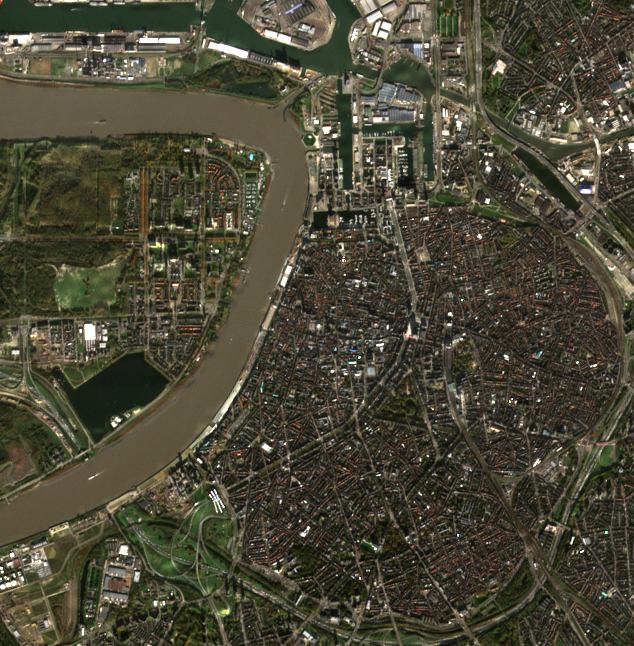

In [587]:
display_rgb(datacube[:,:,:,3])

### Clouds

In [588]:
from rasterio.enums import Resampling
from scipy.ndimage import zoom

In [589]:
def read_cloud_mask(item):
    aoi_bounds = features.bounds(area_of_interest)
    with rasterio.open(item.assets["SCL"].href) as ds:        
        warped_aoi_bounds = warp.transform_bounds(src_crs, ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        cloud_mask = ds.read(window=aoi_window)

        # Calculate the zoom factor
        zoom_factors = 2

        # Perform nearest-neighbor interpolation
        cloud_mask_resampled = zoom(cloud_mask[0,:,:], zoom_factors, order=0)

        # If the cloud mask has values other than 0 and 1, you might want to threshold it
        cloud_mask_resampled = (cloud_mask_resampled>=8).astype(rasterio.uint8)
        
        cloud_mask_resampled = np.expand_dims(cloud_mask_resampled, axis=-1)        
        return cloud_mask_resampled

In [590]:
datacube_clouds = None
for i in indices:
    item = items[i]
    band_data = np.expand_dims(read_cloud_mask(item), axis=-1)
    if len(np.shape(band_data)) > 1 and datacube_clouds is None :
        datacube_clouds = band_data
    elif len(np.shape(band_data)) > 1 and datacube_clouds is not None:
        datacube_clouds = np.concatenate((datacube_clouds, band_data), axis=3)

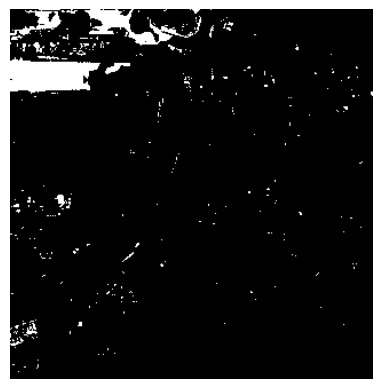

In [591]:
# Display the image
plt.imshow(datacube_clouds[:,:,0,3], cmap='gray')
plt.axis('off')  # Hide the axis values
plt.show()

In [592]:
np.max(datacube_clouds[:,:,0,0])

1

In [593]:
eo.ext(items[indices[0]]).cloud_cover

9.537264

In [594]:
np.mean(datacube_clouds[:,:,0,0])

0.4317371643992148

These numbers differ as the cloud_cover property is of the whole product vs the area of interest.

In [595]:
# Mask the satellite image using the cloud mask
datacube_masked = np.where(datacube_clouds == 1, np.nan, datacube)  # Replace clouded pixels with NaN

In [596]:
np.shape(datacube_masked)

(646, 634, 3, 5)

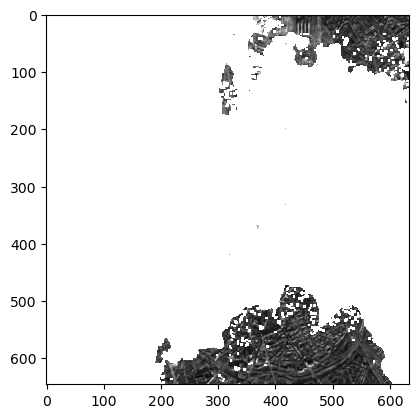

In [597]:
import matplotlib.pyplot as plt

plt.imshow(datacube_masked[:,:,0,0], cmap='gray')  # Assuming the first band
plt.show()

### NIR

In [598]:
def read_nir(item):
    aoi_bounds = features.bounds(area_of_interest)
    with rasterio.open(item.assets["B08"].href) as ds:
        warped_aoi_bounds = warp.transform_bounds(src_crs, ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = np.transpose(ds.read(window=aoi_window), axes=[1, 2, 0])
        band_data = np.where(band_data == 0, np.nan, band_data)
        return band_data

In [599]:
datacube_nir = None
for i in indices:
    item = items[i]
    band_data = np.expand_dims(read_nir(item), axis=-1)
    if len(np.shape(band_data)) > 1 and datacube_nir is None :
        datacube_nir = band_data
    elif len(np.shape(band_data)) > 1 and datacube_nir is not None:
        datacube_nir = np.concatenate((datacube_nir, band_data), axis=3)

In [600]:
datacube_nir.dtype

dtype('float64')

In [601]:
np.nanmin(datacube_nir)

1.0

In [602]:
np.nanmax(datacube_nir)

15984.0

In [603]:
datacube_nir_masked = np.where(datacube_clouds == 1, np.nan, datacube_nir)  # Replace clouded pixels with NaN

In [604]:
nir_max = np.nanmax(datacube_nir_masked)

In [605]:
nir_max = 10000

In [606]:
np.nanmean(datacube_nir_masked)

1255.613319433186

In [607]:
np.nanmin(datacube_nir_masked)

1.0

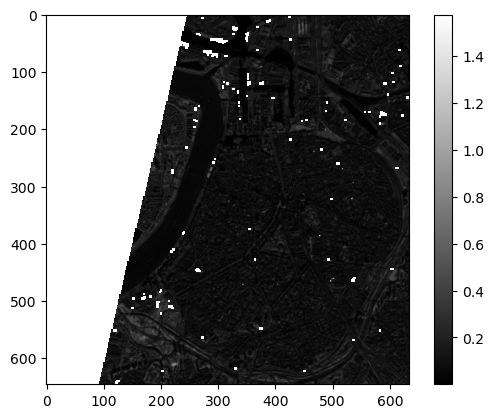

In [608]:
plt.imshow(datacube_nir_masked[:,:,0,1]/nir_max, cmap='gray')
plt.colorbar()
plt.show()

False Color Composite (FCC)

In [609]:
comp = np.dstack((datacube_nir[:,:,0,0]/nir_max, datacube[:,:,0,0]/255, datacube[:,:,1,0]/255))
np.shape(comp)

(646, 634, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


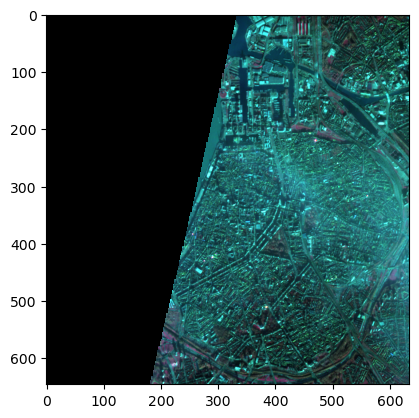

In [610]:
plt.imshow(comp)
plt.show()

### Median

In [611]:
median_r_norm = np.nanmedian(datacube_masked, axis=3)[:,:,0]/255

In [612]:
median_nir_norm = np.nanmedian(datacube_nir_masked, axis=3)[:,:,0]/nir_max

In [613]:
np.shape(median_r_norm)

(646, 634)

In [614]:
np.nanmax(median_nir_norm)

1.214

In [615]:
np.nanmean(median_nir_norm)

0.1322915529939969

### NDVI

In [616]:
# Compute NDVI
ndvi = (median_nir_norm - median_r_norm) / (median_nir_norm + median_r_norm + 1e-8)

In [617]:
np.nanmax(ndvi)

0.6332178078143234

In [618]:
np.nanmean(ndvi)

-0.3781302979183126

In [619]:
filename = 'reprojected_' + str(time_of_interest.replace('/', '_')) + '.png'
filename

'reprojected_2020-10-01_2020-12-31.png'

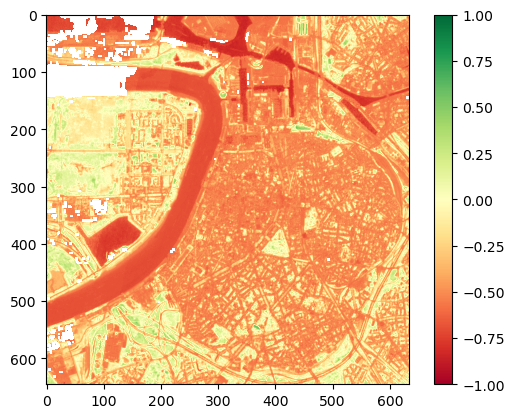

In [620]:
# Visualize NDVI
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.savefig(filename)
plt.show()

### Writing

In [621]:
filename = 'reprojected_' + str(time_of_interest.replace('/', '_')) + '.tif'
filename

'reprojected_2020-10-01_2020-12-31.tif'

In [622]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import from_origin

# Sample data
data = ndvi
dst_crs = 'EPSG:3035'  # Destination CRS

# Assuming you have some metadata about the original data
# Is this correct ??? 
transform = rasterio.windows.transform(aoi_window, ds.transform)
height, width = data.shape

# Calculate the new transform and dimensions for the reprojected data
dst_transform, dst_width, dst_height = calculate_default_transform(
    src_crs, dst_crs, width, height, *warped_aoi_bounds)

# Create a destination numpy array to hold the reprojected data
dst_data = np.empty((dst_height, dst_width))

# Reproject the data
reproject(
    source=data,
    destination=dst_data,
    src_transform=transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Save the reprojected data as a GeoTIFF
with rasterio.open(filename, 'w', driver='GTiff', height=dst_height, width=dst_width, count=1, dtype=dst_data.dtype, crs=dst_crs, transform=dst_transform) as dst:
    dst.write(dst_data, 1)

CPLE_AppDefinedError: Too many points (441 out of 441) failed to transform, unable to compute output bounds.